In [88]:
%matplotlib inline
%env OMP_NUM_THREADS=10
%pylab inline
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [12, 12]

import cv2
from matplotlib.colors import LinearSegmentedColormap

from typing import List
import random

env: OMP_NUM_THREADS=10
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
import g2o

def sample_ellipse(cx, cy, a, b):
    t = np.linspace(0, 2*np.pi, 100)
    x = cx + a * np.cos(t)
    y = cy + b * np.sin(t)
    return x,y

In [90]:
class VertexEclipse(g2o.VectorXVertex):
    """A circle parameterized by position x,y with radius a,b """

    def __init__(self) -> None:
        g2o.VectorXVertex.__init__(self)
        self.set_dimension(4)
        self.set_estimate([0] * 4)

    def oplus_impl(self, update) -> None:
        self.set_estimate(self.estimate() + update)
       
class VertexTheta(g2o.VectorXVertex):
    """A angle of point on eclipse parameterized by theta """

    def __init__(self) -> None:
        g2o.VectorXVertex.__init__(self)
        self.set_dimension(1)
        self.set_estimate([0])

    def oplus_impl(self, update) -> None:
        self.set_estimate(self.estimate() + update)
    
class EdgePointOnEclipse(g2o.VariableVectorXEdge):
    def __init__(self) -> None:
        g2o.VariableVectorXEdge.__init__(self)
        self.set_dimension(1)  # dimension of the error function
        self.information()
        self.resize(2)  # number of vertices
        self.set_measurement([0, 0])  # initial measurement

    def compute_error(self):
        eclipse = self.vertex(0).estimate()
        theta = self.vertex(1).estimate()
        
        cx = eclipse[0]
        cy = eclipse[1]
        
        a = eclipse[2]
        b = eclipse[3]
        estimate = np.array([a * np.cos(theta) + cx, b * np.sin(theta) + cy]).squeeze()
        
        error = np.linalg.norm(self.measurement() -  estimate)
        #print(self.measurement() ,  estimate)
        return [error]

In [91]:
num_points: int = 100
max_iterations: int = 100
verbose: bool = True
# TODO: Parse from command line

# Setup the optimizer
optimizer = g2o.SparseOptimizer()
solver = g2o.BlockSolverSE3(g2o.LinearSolverDenseSE3())
solver = g2o.OptimizationAlgorithmLevenberg(solver)
optimizer.set_algorithm(solver)

In [92]:
# generate random data
center: np.ndarray = np.array([4, 8])
A: float = 2.0
B: float = 10
points: List[np.array] = []

for _ in range(num_points):
    a = random.gauss(A, 0.05)
    b = a * B/A
    angle = random.uniform(0.0, 2.0 * np.pi)
    points.append(center + np.array([a * np.cos(angle), b * np.sin(angle)]))

In [93]:
init_cx = np.array(points)[:,0].mean()
init_cy = np.array(points)[:,1].mean()
print(init_cx,init_cy)

eclipse: VertexEclipse = VertexEclipse()
eclipse.set_id(0)
eclipse.set_estimate([init_cx, init_cy, 2.0,2.0])  # some initial value for the circle
optimizer.add_vertex(eclipse)

3.9696915032617643 7.803897747002996


True

In [94]:
# 2. add the points we measured
for i,point in enumerate(points,1):
    
    t = np.arctan((point[1] - init_cy)/ (point[0] - init_cx))
    
    theta: VertexTheta = VertexTheta()
    theta.set_id(i)
    theta.set_estimate([t])
    
    optimizer.add_vertex(theta)

    edge: EdgePointOnEclipse = EdgePointOnEclipse()
    edge.set_information(np.identity(1))
  
    edge.set_vertex(0, eclipse)
    edge.set_vertex(1, theta)

    edge.set_measurement(point)
    # print(f"error: {edge.compute_error()}")
    # print(f"edge slots: {dir(edge)}")
    optimizer.add_edge(edge)

In [95]:
print(f"Number of vertices: {len(optimizer.vertices())}")
print(f"Number of edges: {len(optimizer.edges())}")

Number of vertices: 101
Number of edges: 100


In [96]:
# perform the optimization
optimizer.initialize_optimization()
optimizer.set_verbose(verbose)
optimizer.optimize(max_iterations)

iteration= 0	 chi2= 5585.153020	 time= 0.0646302	 cumTime= 0.0646302	 edges= 100	 schur= 0	 lambda= 583.605667	 levenbergIter= 7
iteration= 1	 chi2= 5458.419257	 time= 0.0375163	 cumTime= 0.102147	 edges= 100	 schur= 0	 lambda= 194.535222	 levenbergIter= 1
iteration= 2	 chi2= 5221.215256	 time= 0.0376029	 cumTime= 0.139749	 edges= 100	 schur= 0	 lambda= 129.690148	 levenbergIter= 1
iteration= 3	 chi2= 5125.752848	 time= 0.0374559	 cumTime= 0.177205	 edges= 100	 schur= 0	 lambda= 86.460099	 levenbergIter= 1
iteration= 4	 chi2= 5100.179059	 time= 0.0419036	 cumTime= 0.219109	 edges= 100	 schur= 0	 lambda= 57.640066	 levenbergIter= 1
iteration= 5	 chi2= 5073.764757	 time= 0.048305	 cumTime= 0.267414	 edges= 100	 schur= 0	 lambda= 76.853421	 levenbergIter= 2
iteration= 6	 chi2= 5054.821237	 time= 0.0416222	 cumTime= 0.309036	 edges= 100	 schur= 0	 lambda= 102.471228	 levenbergIter= 2
iteration= 7	 chi2= 5035.652658	 time= 0.0441414	 cumTime= 0.353178	 edges= 100	 schur= 0	 lambda= 34.15707

100

3.795660600413387 8.018563746750464 0.2847993428810715 -9.667454977352005


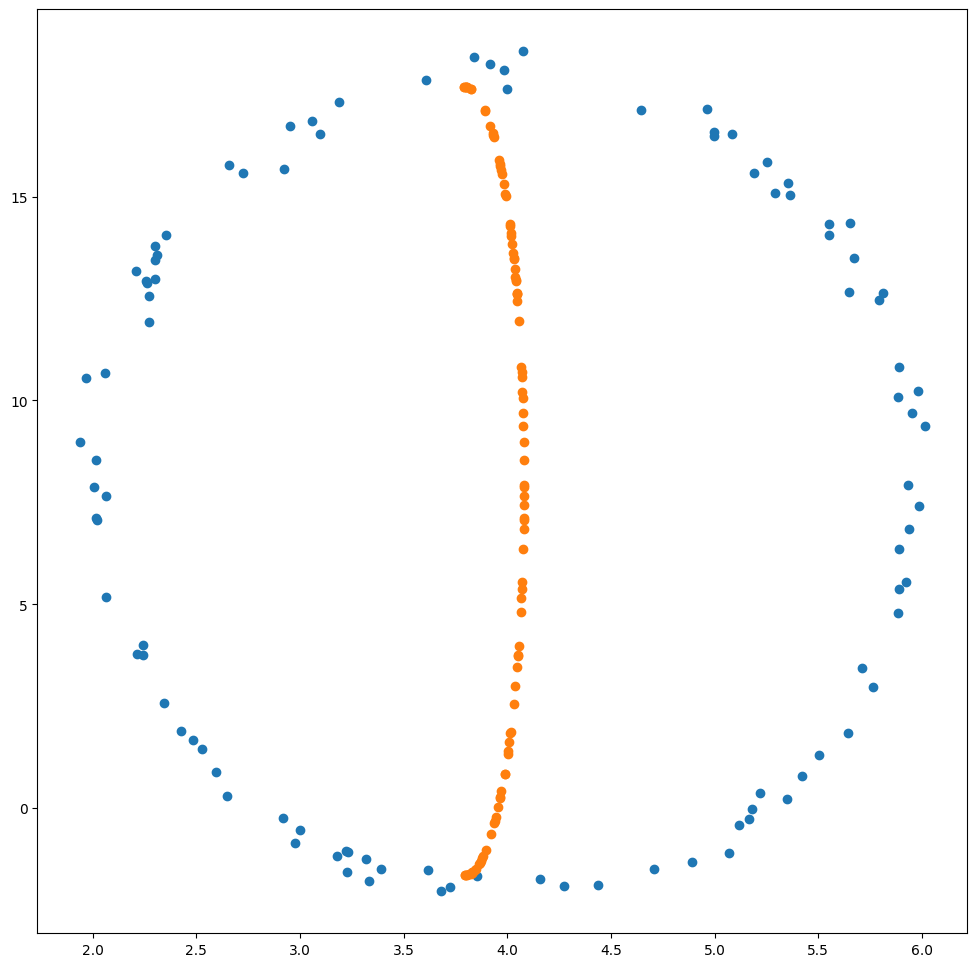

In [97]:
cx_est,cy_est,a_est,b_est = optimizer.vertices()[0].estimate()
#est_eclipse_xs, est_eclipse_ys = sample_ellipse(cx_est,cy_est,a_est,b_est)


est_eclipse_xs = []
est_eclipse_ys = []
for i in range(1,num_points):
    est_th = optimizer.vertices()[i].estimate()[0]
    
    est_eclipse_xs.append(cx_est + a_est * np.cos(est_th))
    est_eclipse_ys.append(cy_est + b_est * np.sin(est_th))

print(cx_est,cy_est,a_est,b_est)

dd = np.array(points).T
plt.scatter(dd[0,:],dd[1,:])
plt.scatter(est_eclipse_xs,est_eclipse_ys)